In [2]:
import os

import keras
import numpy
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, model_from_json

WORKING_DIR = %pwd

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [4]:
batch_size = 128
num_classes = 10 # because there are 10 different types of clothes
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

In [5]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train /= 255
X_test /= 255
print('x_train shape:', x_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Keep in mind that we need `x_text` and `X_test`, `y_test` and `Y_test` (variables with lower and upper case) and so on. 

In [8]:
weights_path = os.path.join(WORKING_DIR, 'weights.h5')
model_path = os.path.join(WORKING_DIR, 'model.json')
history_path = os.path.join(WORKING_DIR, 'history.csv')
print(os.path.exists(weights_path))

True


In [9]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(history_path, append=True, separator=';')

def create_model(x_train, y_train, x_test, y_test, **kwargs):
    batch_size = kwargs.get('batch_size')
    epochs = kwargs.get('epochs')
    num_classes = kwargs.get('num_classes')

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test), 
                        callbacks=[csv_logger])
    return model


In [10]:
if os.path.exists(weights_path) and os.path.exists(model_path):
    # load json and create model
    with open(model_path, 'r') as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(weights_path)
    print("Loaded model from disk")
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
else:
    model = create_model(X_train, Y_train, X_test, Y_test, batch_size=batch_size,
                                  epochs=epochs, num_classes=num_classes)
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_path)
    print("Saved model to disk")

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Loaded model from disk


Test loss: 0.241380548894
Test accuracy: 0.9145


In [11]:
import pandas as pd

history = pd.read_csv(history_path, delimiter=';')

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history['acc']
val_accuracy = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

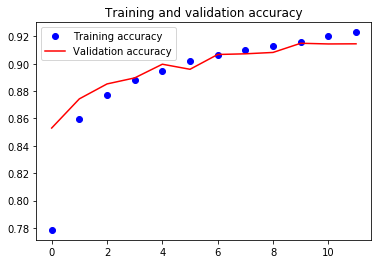

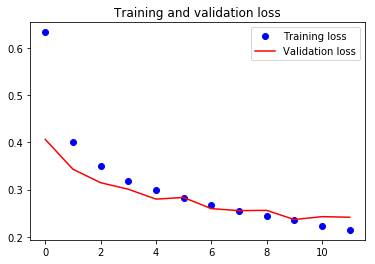

In [13]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
import numpy as np

#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

#get the indices to be plotted
correct = np.nonzero(predicted_classes == y_test)[0]
incorrect = np.nonzero(predicted_classes != y_test)[0]


In [18]:
from sklearn.metrics import classification_report

target_names = ["Class {}".format(i) for i in range(num_classes)]

In [19]:
print(classification_report(y_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.83      0.91      0.87      1000
    Class 1       0.99      0.98      0.99      1000
    Class 2       0.85      0.89      0.87      1000
    Class 3       0.91      0.94      0.92      1000
    Class 4       0.85      0.88      0.87      1000
    Class 5       0.99      0.97      0.98      1000
    Class 6       0.83      0.65      0.73      1000
    Class 7       0.96      0.96      0.96      1000
    Class 8       0.97      0.98      0.98      1000
    Class 9       0.96      0.98      0.97      1000

avg / total       0.91      0.91      0.91     10000



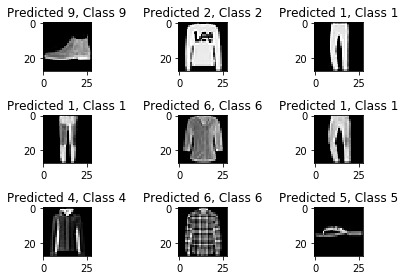

In [20]:
for i, correct in enumerate(correct[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[correct].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()


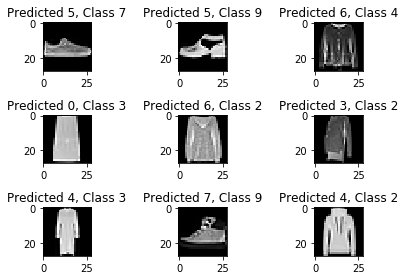

In [21]:
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[incorrect].reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()


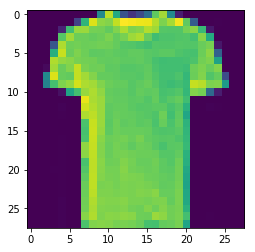

In [22]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28, 28), cmap='viridis', interpolation='none')
plt.show()


In [1]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1, 28, 28, 1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')


Using TensorFlow backend.


NameError: name 'model' is not defined

In [2]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                row * size: (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


NameError: name 'model' is not defined